## Convolutional Neural Networks with Image Augmentation

## About the Data
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and optimal for real-world applications. In one recent replacement called the Fashion-MNIST dataset, researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To encourage the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same .CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The full introduction can be seen here: https://www.kaggle.com/datamunge/sign-language-mnist/home

This type of computations may be long, so it is recommended to start with timer setting so you will know how much time the script will take.

In [9]:
import time
from time import perf_counter as timer

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [11]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Find the dimension of the dataframe:

In [12]:
train.shape

(27455, 785)

The train set is reworked to reduce data size. In particular, all images are in grayscale and their sizes are 28 * 28 pixels.

## Data Preprocessing
First, start to extract information from the data by looking at labels:

In [13]:
labels = train['label'].values

unique_val = np.array(labels)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

See if your data is balanced:

<AxesSubplot:ylabel='count'>

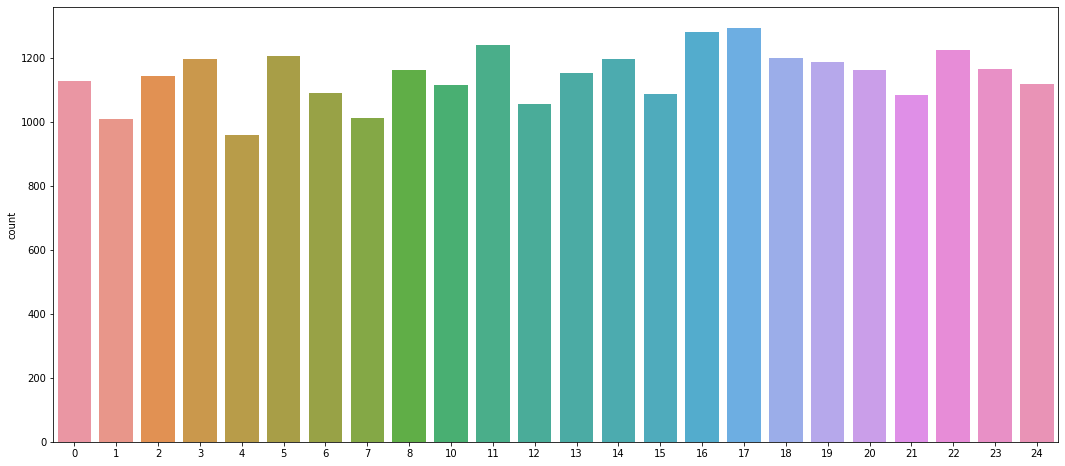

In [14]:
plt.figure(figsize = (18,8))
sns.countplot(x =labels)

As you can see from the plot, all output numbers are about the same.

For your CNN network you should create an output array with Label Binarizer from the labels.

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

Now you can drop the label column from the 'train' set and work with the rest of data.

In [16]:
train.drop('label', axis = 1, inplace = True)

Now take out the image information from the train object and put it into a numpy array. What is the data type? What are the range and dimensions?

In [17]:
images = train.values
print(images.dtype, np.round(images.min(), 4), np.round(images.max(), 4), images.shape)

int64 0 255 (27455, 784)


Display the provided images in the first 5 rows:

Text(0.5, 0.98, 'Grayscale images')

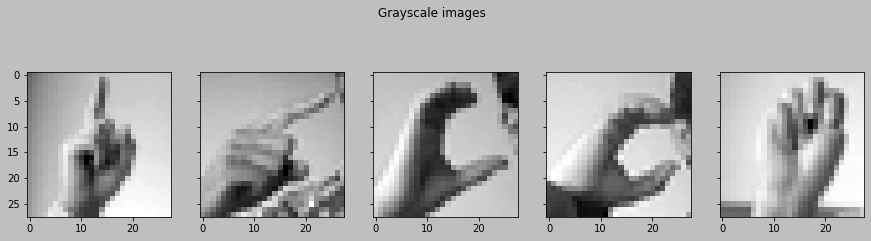

In [18]:
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5): 
        axs[i].imshow(images[i].reshape(28,28))
fig.suptitle('Grayscale images')

Normalize the data before applying the CNN. The data values range from 0 to 255, so you should normalize and divide every entry by 225:

In [19]:
images =  images/255

For validation during a model fitting you will need to divide your train set into two parts:

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, stratify = labels, random_state = 7)

Now reshape the rows as square tables in order to use a Convolution Neural Network method:

In [21]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

## Convolutional Neural Network Model, or CNN

For CNN, use the following Keras library:

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

Set a number of classes, a batch size and a number of epochs:

In [23]:
num_classes = 24
batch_size = 125
epochs = 50

model = Sequential()
model.add(Conv2D(64, kernel_size=(4,4), activation = 'relu', input_shape=(28, 28 ,1), padding='same' ))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (4, 4), activation = 'relu', padding='same' ))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(loss = keras.losses.categorical_crossentropy, optimizer='nadam',
              metrics=['accuracy'])


This part is for image augmentation during model fitting

###Try adjusting these parameters and observe the difference in results

In [24]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(shear_range = 0.25,
                                   zoom_range = 0.15,
                                   rotation_range = 15,
                                   brightness_range = [0.15, 1.15],
                                   width_shift_range = [-2,-1, 0, +1, +2],
                                   height_shift_range = [ -1, 0, +1],
                                   fill_mode = 'reflect')
test_datagen = ImageDataGenerator()

In [25]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/50
154/154 [==============================] - 11s 68ms/step - loss: 2.2454 - accuracy: 0.3137 - val_loss: 1.8102 - val_accuracy: 0.6627
Epoch 2/50
154/154 [==============================] - 11s 69ms/step - loss: 0.7257 - accuracy: 0.7570 - val_loss: 0.9146 - val_accuracy: 0.9241
Epoch 3/50
154/154 [==============================] - 14s 93ms/step - loss: 0.3420 - accuracy: 0.8851 - val_loss: 0.5796 - val_accuracy: 0.9653
Epoch 4/50
154/154 [==============================] - 19s 124ms/step - loss: 0.1889 - accuracy: 0.9351 - val_loss: 0.3485 - val_accuracy: 0.9977
Epoch 5/50
154/154 [==============================] - 19s 123ms/step - loss: 0.1183 - accuracy: 0.9592 - val_loss: 0.2429 - val_accuracy: 0.9987
Epoch 6/50
154/154 [==============================] - 19s 121ms/step - loss: 0.0831 - accuracy: 0.9723 - val_loss: 0.1898 - val_accuracy: 0.9990
Epoch 7/50
154/154 [==============================] - 19s 121ms/step - loss: 0.0568 - accuracy: 0.9815 - val_loss: 0.1364 - val_accur

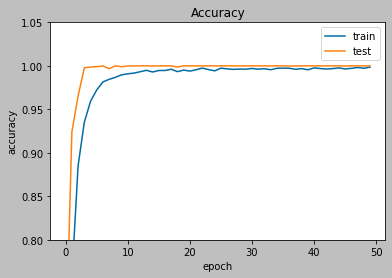

In [29]:
plt.style.use('tableau-colorblind10')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.80, 1.05)
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

Validate with the test data. At first it must be preprocessed in the same way as the data for model fitting. This means that you must remove its label column, divide all values by 225, and the rows should be reshaped as square arrays.

In [30]:
test_labels = test['label']
test.drop('label', axis = 1, inplace = True)
test_images = test.values/255
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
test_images.shape

(7172, 28, 28, 1)

Here are the predictions and accuracy of the provided test set.

In [31]:
y_pred = model.predict(test_images)
from sklearn.metrics import accuracy_score
y_pred = y_pred.round()
accuracy_score(test_labels, y_pred)

0.9846625766871165